<a href="https://colab.research.google.com/github/yoheikikuta/TensorFlow2-check/blob/master/colab/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAE with subclassing API

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf

TensorFlow 2.x selected.


In [2]:
tf.__version__

'2.0.0-rc2'

In [0]:
(x_train, _), _ = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255

train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(buffer_size=60000).batch(64)

for elem in train_dataset:
    check_data = elem
    break

In [4]:
check_data

<tf.Tensor: id=17, shape=(64, 784), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [0]:
import numpy as np
from tensorflow.keras import layers

In [0]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [7]:
z_mean = tf.constant([[1, 2, 3], [10,  20,  30]], dtype=tf.float32)
z_mean

<tf.Tensor: id=18, shape=(2, 3), dtype=float32, numpy=
array([[ 1.,  2.,  3.],
       [10., 20., 30.]], dtype=float32)>

In [8]:
test = Sampling()
inputs = (z_mean, 1.0)
test.call(inputs)

<tf.Tensor: id=38, shape=(2, 3), dtype=float32, numpy=
array([[-0.6145017,  1.350303 ,  2.1132748],
       [ 9.547177 , 17.470734 , 27.888798 ]], dtype=float32)>

In [0]:
class Encoder(layers.Layer):
    """Maps MNIST digits to a triplet (z_mean, z_log_var, z)."""

    def __init__(self,
                latent_dim=32,
                name='encoder',
                **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        self.reshaped_input = layers.Reshape((28, 28, 1))
        self.conv2d_1 = layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu')
        self.conv2d_2 = layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu')
        self.flatten = layers.Flatten()
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)
        self.sampling = Sampling()

    def call(self, inputs):
        x = self.reshaped_input(inputs)
        x = self.conv2d_1(x)
        x = self.conv2d_2(x)
        x = self.flatten(x)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z

In [0]:
test = Encoder(latent_dim=5)

In [0]:
z_mean, z_log_var, z = test.call(check_data)

In [12]:
print(z_mean.shape)
z_mean[0]

(64, 5)


<tf.Tensor: id=183, shape=(5,), dtype=float32, numpy=
array([-0.05300835, -0.03907587, -0.00652128,  0.03132723,  0.17980152],
      dtype=float32)>

In [13]:
print(z_log_var.shape)
z_log_var[0]

(64, 5)


<tf.Tensor: id=187, shape=(5,), dtype=float32, numpy=
array([-0.03819917, -0.09629977,  0.03349521,  0.05942789, -0.06784695],
      dtype=float32)>

In [14]:
z[0]

<tf.Tensor: id=191, shape=(5,), dtype=float32, numpy=
array([-1.5637307 , -1.1443948 ,  1.4833997 , -0.57705235,  0.57865447],
      dtype=float32)>

In [0]:
class Decoder(layers.Layer):
    """Converts z, the encoded digit vector, back into a readable digit."""

    def __init__(self,
                latent_dim=32,
                name='decoder',
                **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.dense = layers.Dense(7 * 7 * 32, activation='relu', input_shape=(latent_dim,))
        self.reshaped_input = layers.Reshape((7, 7, 32))
        self.convtr2d_1 = layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu')
        self.convtr2d_2 = layers.Conv2DTranspose(filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu')
        self.convtr2d_3 = layers.Conv2DTranspose(filters=1, kernel_size=3, strides=(1, 1), padding="SAME")
        self.original_shape = layers.Reshape((784,))

    def call(self, inputs):
        x = self.dense(inputs)
        x = self.reshaped_input(x)
        x = self.convtr2d_1(x)
        x = self.convtr2d_2(x)
        x = self.convtr2d_3(x)
        x = self.original_shape(x)
        return x

In [0]:
test = Decoder()

In [17]:
test.call(tf.expand_dims(z[0], 0)).shape

TensorShape([1, 784])

In [0]:
class VariationalAutoEncoder(tf.keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(self,
                latent_dim=32,
                name='autoencoder',
                **kwargs):
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        self.encoder = Encoder(latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim)

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        # KL divergence regularization loss.
        kl_loss = - 0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)

        return kl_loss, reconstructed

In [19]:
%%time
# original_dim = 784
vae = VariationalAutoEncoder(32)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
mse_loss_fn = tf.keras.losses.MeanSquaredError()

loss_metric = tf.keras.metrics.Mean()

(x_train, _), _ = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255.

x_train[x_train >= .5] = 1.
x_train[x_train < .5] = 0.

train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(buffer_size=60000).batch(100)

# Iterate over epochs.
for epoch in range(5):
    print('Start of epoch %d' % (epoch,))

    # Iterate over the batches of the dataset.
    for step, x_batch_train in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            kl_loss, reconstructed = vae(x_batch_train)
            # Compute reconstruction loss
            loss = mse_loss_fn(x_batch_train, reconstructed)
            loss += kl_loss

        grads = tape.gradient(loss, vae.trainable_weights)
        optimizer.apply_gradients(zip(grads, vae.trainable_weights))

        loss_metric(loss)

        if step == 0:
            print('step %s: mean loss = %s' % (step, loss_metric.result()))

Start of epoch 0
step 0: mean loss = tf.Tensor(0.13763827, shape=(), dtype=float32)
Start of epoch 1
step 0: mean loss = tf.Tensor(0.09586437, shape=(), dtype=float32)
Start of epoch 2
step 0: mean loss = tf.Tensor(0.09177711, shape=(), dtype=float32)
Start of epoch 3
step 0: mean loss = tf.Tensor(0.090209216, shape=(), dtype=float32)
Start of epoch 4
step 0: mean loss = tf.Tensor(0.08935449, shape=(), dtype=float32)
CPU times: user 1min 37s, sys: 3.96 s, total: 1min 41s
Wall time: 1min 51s


## Reconstruction

In [20]:
x_batch_train.shape

TensorShape([100, 784])

In [0]:
# reconstructed = vae(x_batch_train)

In [0]:
from matplotlib import pyplot as plt

In [0]:
def draw_digit(data, row, col, n):
    plt.subplot(row, col, n)
    plt.imshow(data)
    plt.gray()

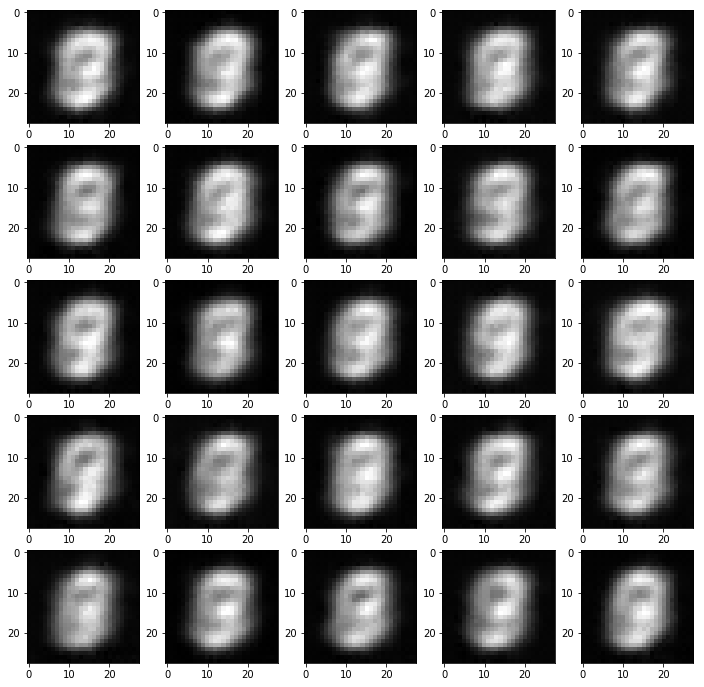

In [24]:
show_size = 5
total = 0
plt.figure(figsize=(12, 12))
for i in range(show_size):
    for j in range(show_size):
        draw_digit(np.array(reconstructed)[total].reshape(28, 28), show_size, show_size, total+1)
        total += 1
plt.show()

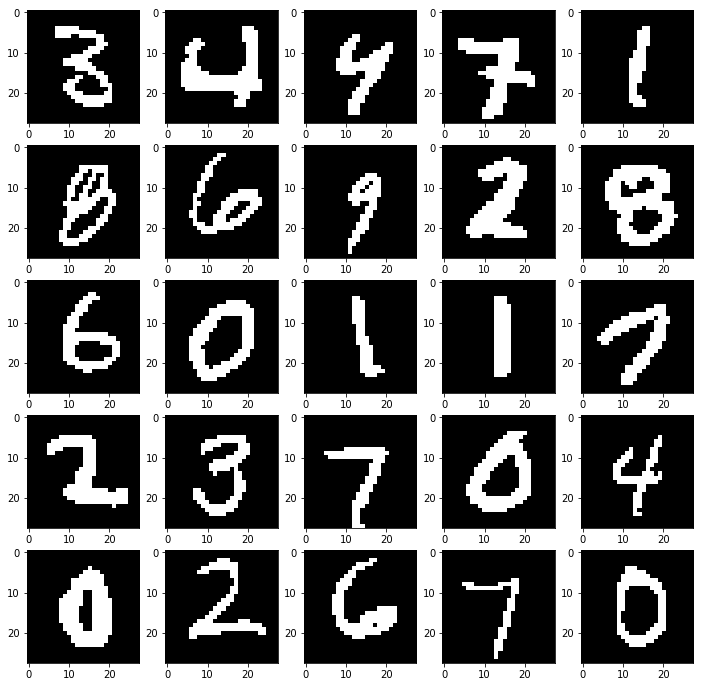

In [25]:
show_size = 5
total = 0
plt.figure(figsize=(12, 12))
for i in range(show_size):
    for j in range(show_size):
        draw_digit(np.array(x_batch_train[total]).reshape(28, 28), show_size, show_size, total+1)
        total += 1
plt.show()

NOT WORKING YET...

# Trial and Errors

In [23]:
(x_train, _), _ = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255

train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

11493376/11490434 [==============================] - 0s 0us/step


In [25]:
x_train.shape

(60000, 784)

In [26]:
train_dataset

<BatchDataset shapes: (None, 784), types: tf.float32>

In [0]:
for elem in train_dataset:
    check_data = elem
    break

In [5]:
check_data[0]

<tf.Tensor: id=21, shape=(784,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       

In [12]:
layers.Reshape((28, 28, 1))(check_data[0])

InvalidArgumentError: ignored

In [14]:
check_data[0].shape

TensorShape([784])

In [22]:
tf.reshape(check_data[0], (28, 28, 1)).shape

TensorShape([28, 28, 1])

In [30]:
layers.InputLayer()(tf.reshape(check_data[0], (28, 28, 1))).shape

TensorShape([28, 28, 1])

In [34]:
layers.Reshape((28, 28), input_shape=(784,))(check_data[0])

InvalidArgumentError: ignored

In [38]:
layers.Reshape((2, 3), input_shape=(6,))(tf.constant([[1,2,3,4,5,6]]))

<tf.Tensor: id=324, shape=(1, 2, 3), dtype=int32, numpy=
array([[[1, 2, 3],
        [4, 5, 6]]], dtype=int32)>

In [39]:
tf.constant([[1,2,3,4,5,6]])

<tf.Tensor: id=325, shape=(1, 6), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6]], dtype=int32)>

In [46]:
layers.Reshape((28, 28, 1))(tf.expand_dims(check_data[0], 0)).shape

TensorShape([1, 28, 28, 1])

In [57]:
layers.Reshape((28, 28, 1))(check_data).shape

TensorShape([64, 28, 28, 1])

In [95]:
layers.Dense(7 * 7 * 32, activation='relu')(tf.expand_dims(z[0], 0))

<tf.Tensor: id=1262, shape=(1, 1568), dtype=float32, numpy=
array([[0.02107626, 0.09664011, 0.        , ..., 0.009658  , 0.04389245,
        0.        ]], dtype=float32)>